In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
# from lesson_functions import *
%matplotlib inline
# from features import *
# from parameters import *
# from windows import *
import os
import pickle

In [3]:
# test_images = np.array([plt.imread(i) for i in glob.glob('dataset/sign-images/*.png')])
# path = 'dataset/Test/'
# for file in os.listdir(path):
#     if file.endswith('.png'):
#         try:
#             image = cv2.imread(os.path.join(path, file))
#             image = cv2.resize(image, (64, 64))
#             cv2.imwrite("dataset/sign-images/"+str(file), image)
#         except:
#             os.remove(os.path.join(path, file))
            
sign_images = []
non_sign_images = []

for root, dirs, files in os.walk('dataset/sign-images/'):
    for file in files:
        if file.endswith('.png'):
            sign_images.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('CarData/non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            non_sign_images.append(os.path.join(root, file))

In [4]:
n_sign_images = len(sign_images)
n_non_sign_images = len(non_sign_images)
img_shape = mpimg.imread(sign_images[0]).shape
print('No. of car images: ', n_sign_images)
print('No of non-car images: ', n_non_sign_images)
print('Image shape: ', img_shape)

No. of car images:  12630
No of non-car images:  10196
Image shape:  (64, 64, 3)


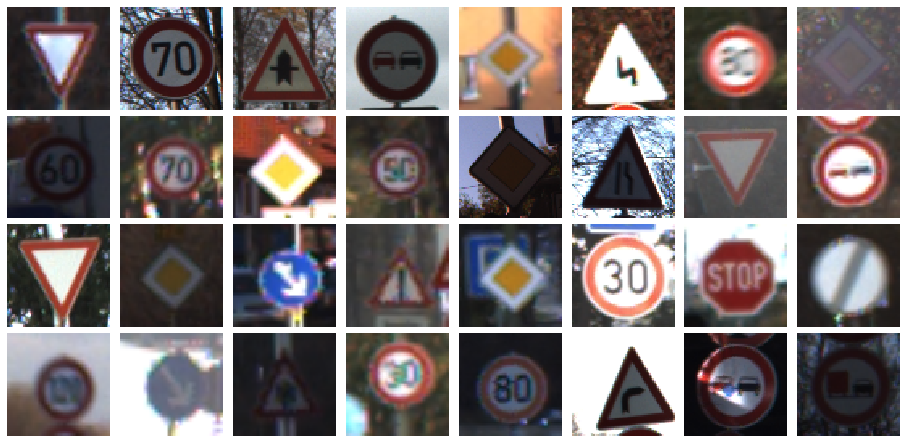

In [5]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(sign_images[np.random.randint(0,n_sign_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('CarData/output/sign_samples.png')

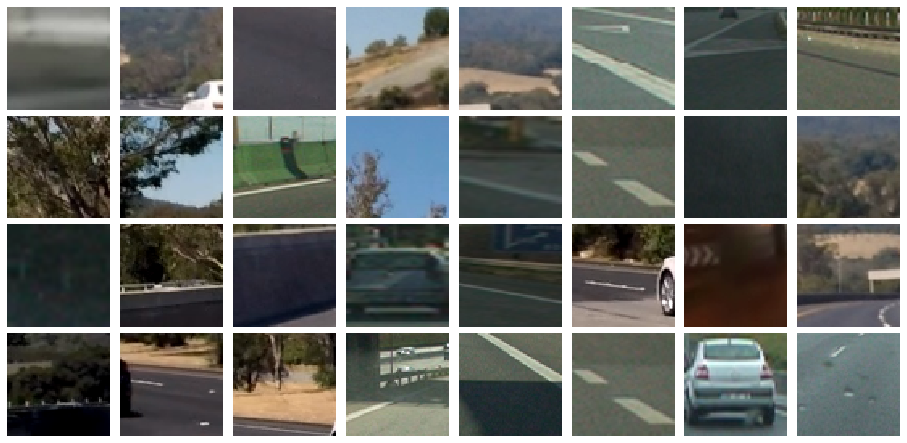

In [6]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(non_sign_images[np.random.randint(0,n_non_sign_images)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
plt.savefig('CarData/output/non_sign_samples.png')

In [3]:
# Compute binned color features by scaling images down 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract feature wrapper that extracts and combines all features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB' 
            
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


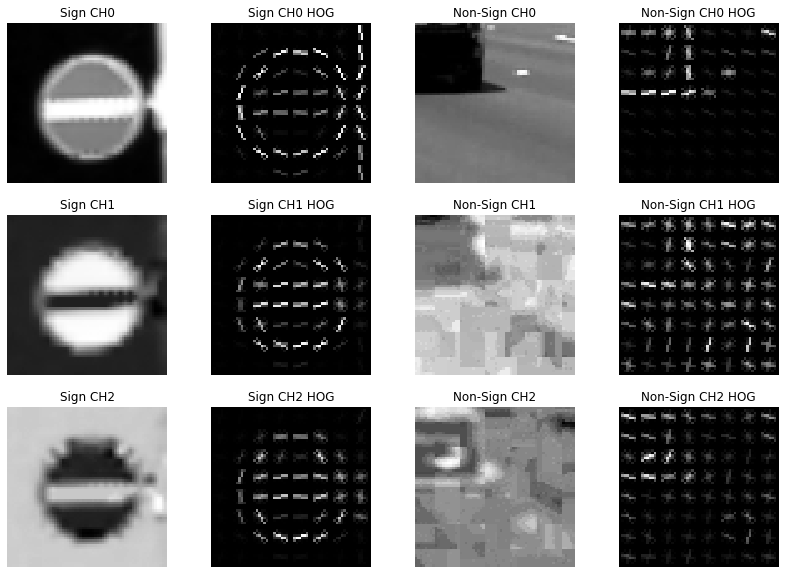

In [8]:
sign_test = mpimg.imread(sign_images[35])
sign_test = cv2.cvtColor(sign_test, cv2.COLOR_RGB2YCrCb)
non_sign_test = mpimg.imread(non_sign_images[20])
non_sign_test = cv2.cvtColor(non_sign_test, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([sign_test, non_sign_test], ['Sign', 'Non-Sign']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.savefig('CarData/output/HOG_comparison.png')

In [4]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]
ystart_ystop_scale = [(220, 300, 1), (250, 330, 1), (280, 360, 1)]

sign_features = extract_features(sign_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

non_sign_features = extract_features(non_sign_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

In [11]:
print(np.array(sign_features).shape)
print(np.array(non_sign_features).shape)

(12630, 8460)
(10196, 8460)


# Data Preparation

In [14]:
import random

# Preserve State to compare parameter tuning 
rand_state = np.random.randint(0, 100)


# Create an array stack of feature vectors
X = np.vstack((sign_features, non_sign_features)).astype(np.float64)       

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(sign_features)), np.zeros(len(non_sign_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


# Classifier

In [15]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

11.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9987
My SVC predicts:      [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
0.002 Seconds to predict 10 labels with SVC


# Saving Model

In [16]:
import pickle 

# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial"] = spatial
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle_some_signs-2.p", 'wb') )

print('Classifier parameters saved to file!')

Classifier parameters saved to file!


# Load Model

In [5]:
# Load

print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle_some_signs-2.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatia = dist_pickle["spatial"]
hist_bins = dist_pickle["hist_bins"]
spatial_size= (32, 32)


print('Loading is done!')

Loading Classifier parameters...
Loading is done!


In [6]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    # List of bounding box positions
    bbox_detection_list=[]
    box_vis_list=[]
    # Copy and normalise
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
       
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features)
                
                if(visualisation):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    bbox_detection_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))
                    # Draw Detection on image
                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_vis_list += [box_vis]
    return bbox_detection_list, draw_img, box_vis_list

In [19]:
test_images = np.array([plt.imread(i) for i in glob.glob('dataset/Detection/*')])

C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


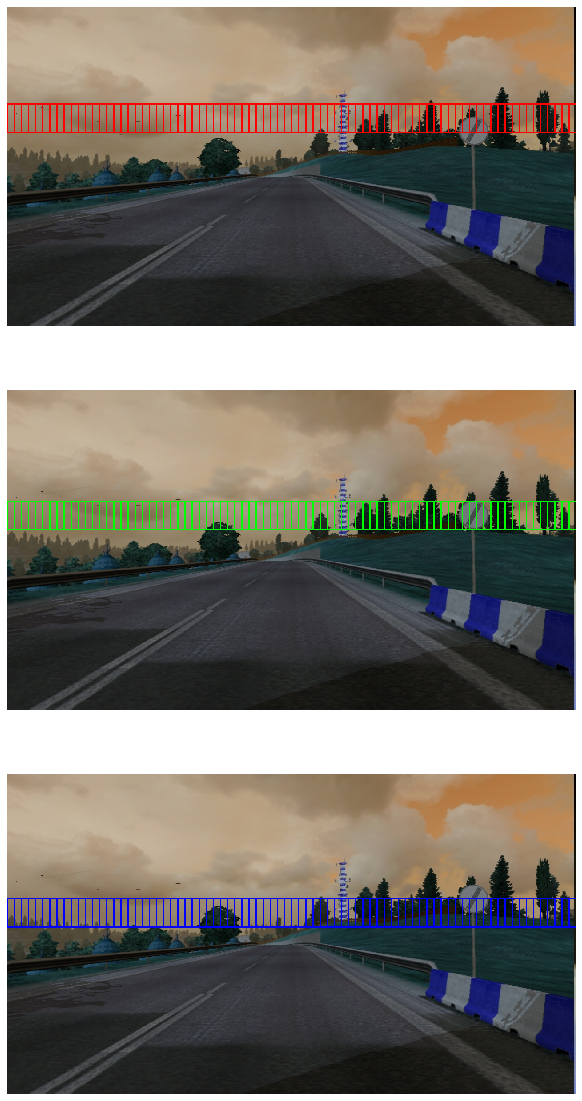

In [25]:
test_image_sliding = cv2.imread("sign_to_detect_11.jpg")
test_image_sliding = cv2.cvtColor(test_image_sliding, cv2.COLOR_BGR2RGB)

bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)

def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]
    color=[(255, 0, 0),(0, 255, 0),(0, 0, 255)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=color[i], thickness=thickness)
    return imcopy

windows_img = draw_boxes(test_image_sliding, box_vis_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
ax1.imshow(windows_img[0])
# title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
# ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
# title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
# ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
# title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
# ax3.set_title(title, fontsize=20)
ax3.axis("off")

plt.savefig('CarData/output/bbox_vis_sign.png')

In [14]:
# Accumulation of labels from last N frames
class Detect_history_sign():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 7 #17 13
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
# cropped = []
def draw_labeled_bboxes(original, img, labels):
    crop_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        try:
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
    #         img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.rectangle(img, (bbox[0]), (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 2)
            crop_it = np.array([ (bbox[0]), ((bbox[1][1]), (bbox[1][0]))])
            crop_list.append(crop_it)
    #         print(crop_it)
        except Exception as e:
            crop_it = None
            print(e)
    # Return the image
    return original, img, crop_list

C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


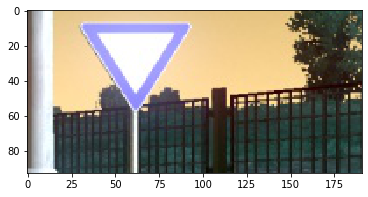

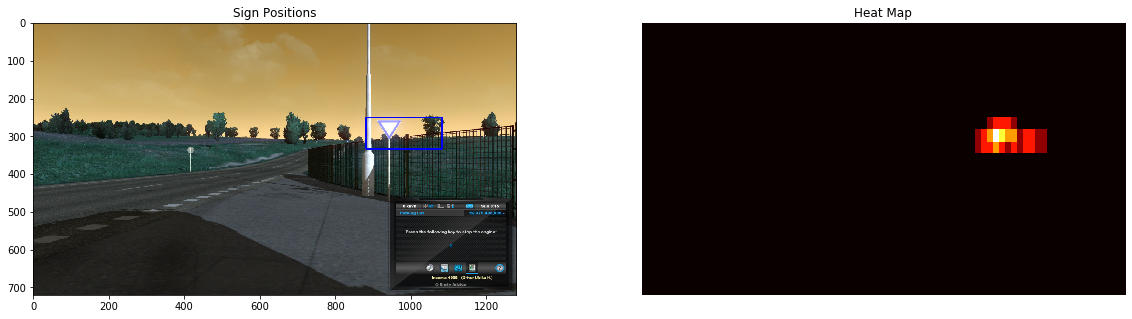

<Figure size 432x288 with 0 Axes>

In [23]:
# Read in image similar to one shown above 
image = plt.imread("sign_to_detect_4.jpg")
blank = np.zeros_like(image[:,:,0]).astype(np.float)

# Using Subsampled HOG windows to get possible detections 
bbox_detection_list, detections, box_vis_list = find_cars(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

# Add heat to each box in box list
heatmap = add_heat(blank, bbox_detection_list)

# Find final boxes from heatmap using label function
labels = label(heatmap)
org, draw_img, get_cropped = draw_labeled_bboxes(plt.imread("sign_to_detect_5.jpg"), np.copy(image), labels)

# Crop detected sign
allCropped = []
for val in get_cropped:
    croppedImage = image[val[0][1]:val[1][0], val[0][0]:val[1][1]]
    allCropped.append(croppedImage)
    plt.imshow(croppedImage)
    plt.show()

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Sign Positions')
plt.axis('on')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off')
plt.show()

plt.savefig('CarData/output/heatmap_sign.png')

# print(get_cropped)

# x = get_cropped[0][0]
# y = get_cropped[0][1]
# x2 = get_cropped[1][1]
# y2 = get_cropped[1][0]

# croppedImage = image2[y:y2, x:x2]


In [16]:
# ### Parameters
# spatial = 32
# hist_bins = 32
# colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# spatial_size= (32, 32)
# heat_threshold= 4 # 12
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
# ystart_ystop_scale = [(0, 100, 1), (0, 200, 1.5), (50, 300, 2.5)]
# ystart_ystop_scale = [(205, 310, 1), (250, 355, 1), (300, 405, 1)]
# ystart_ystop_scale = [(220, 325, 1), (220, 375, 1), (250, 405, 1)]

def process_image(original, img): 
        
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list, detections, box_vis_list = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(img[:,:,0]).astype(np.float)

    # Smoothing out previous detections
    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    # Add heat to detections
    heatmap = add_heat(blank, bbox_detection_list)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    original, res, res_crop = draw_labeled_bboxes(original, np.copy(img), labels)
    
    allCropped = []
    for val in res_crop:
        croppedImage = original[val[0][1]:val[1][0], val[0][0]:val[1][1]]
        allCropped.append(croppedImage)
    
    return original, res, allCropped

In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def equalize_hist(image):
    hist, bins = np.histogram(image.flatten(),256,[0, 256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    img3 = cdf[image]
    
    #cv2.imwrite('data/test_images/ets/test_ets2_3.jpg', img3)
    plt.imshow(cdf[image])
    
    return img3

# Detect & Classify

In [18]:
import tensorflow as tf

In [19]:
loadmodel = tf.keras.models.load_model('Traffic-sign-6.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


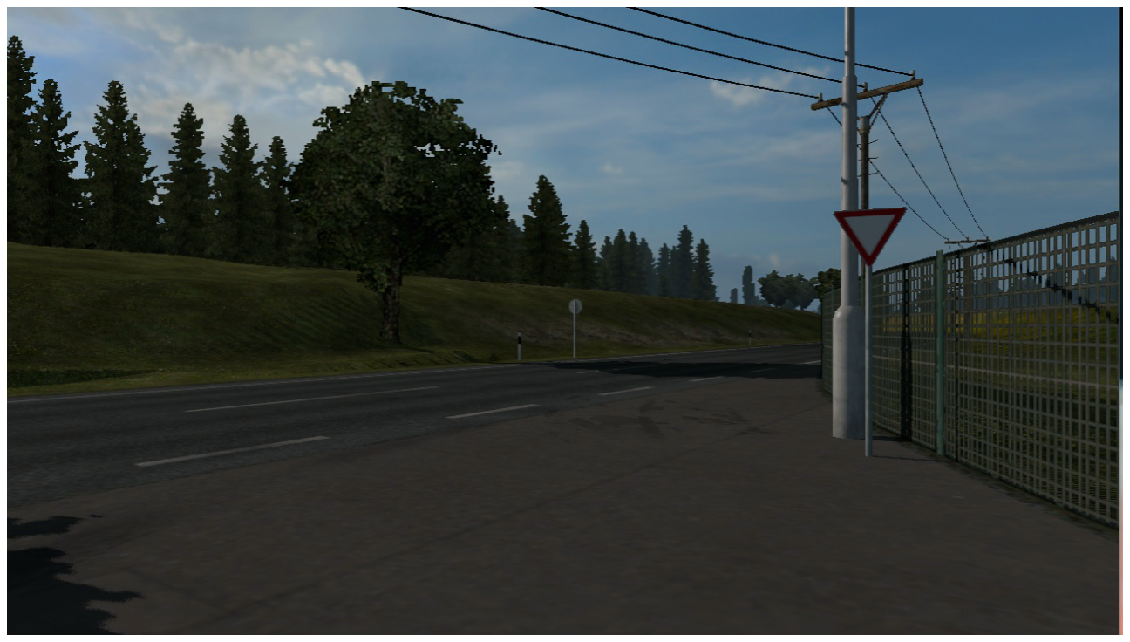

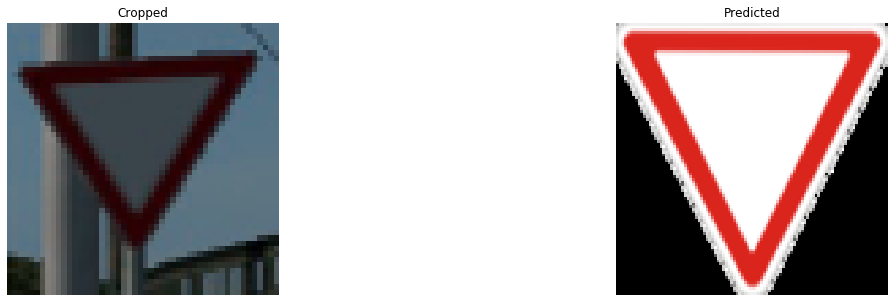

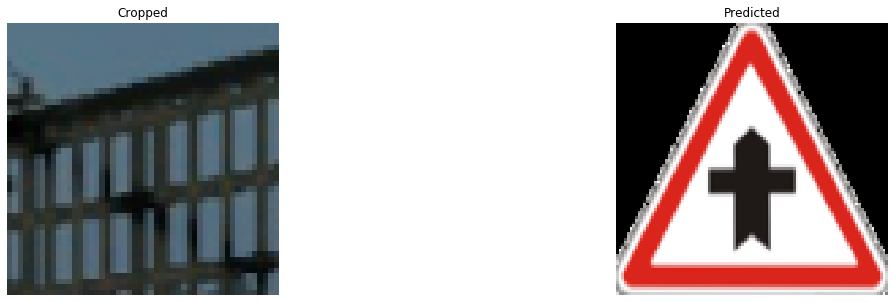

In [26]:
testing_data = []

detect_history = Detect_history_sign()

imageToDet = plt.imread("sign_to_detect_10.jpg")
imageToDet = cv2.cvtColor(imageToDet, cv2.COLOR_BGR2RGB)

org, res1, crop1 = process_image(imageToDet, imageToDet)
plt.figure(figsize = (20,20))
plt.imshow(org)
plt.axis("off")
plt.show()

for singleImage in crop1:
    testing_data = []
    predictImage = cv2.resize(singleImage, (50, 50))

    testing_data.append(predictImage)

    prediction = loadmodel.predict(np.array(testing_data).astype('float32'))

    meta = cv2.imread('dataset/Meta/'+str(np.argmax(prediction))+'.png')
    meta = cv2.resize(meta, (100, 100))
    meta = cv2.cvtColor(meta, cv2.COLOR_BGR2RGB)
#     imageToDet[crop1[0][1]+100:crop1[0][1]+200, crop1[0][0]:crop1[0][0]+100] = meta
    
    fig = plt.figure(figsize = (20,5))
    plt.subplot(121)
    plt.imshow(predictImage)
    plt.title('Cropped')
    plt.axis('off')
    plt.subplot(122)

    plt.imshow(meta)
    plt.title('Predicted')
    plt.axis('off')

#     print("Class : " + str(np.argmax(prediction)))

#     plt.imshow(predictImage)
#     plt.show()

C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
C:\Users\DS\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


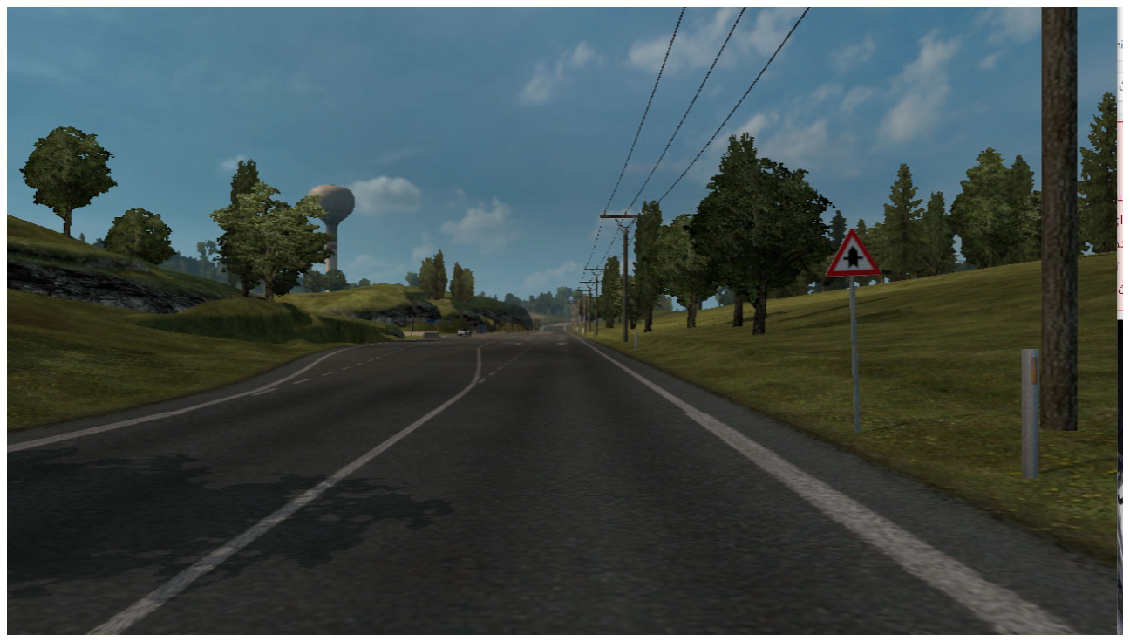

Class : 29


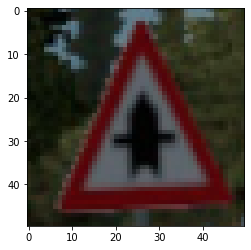

In [106]:
testing_data = []

detect_history = Detect_history_sign()

imageToDet = plt.imread("sign_to_detect_12.jpg")
# maskedImge, croppedImage = mask_image(imageToDet)
imageToRGB = cv2.cvtColor(imageToDet, cv2.COLOR_BGR2RGB)


org, res1, crop1 = process_image(imageToRGB, imageToRGB)
plt.figure(figsize = (20,20))
plt.imshow(org)
plt.axis("off")
plt.show()

for singleImage in crop1:
    testing_data = []
    predictImage = cv2.resize(singleImage, (50, 50))
    testing_data.append(predictImage)

    prediction = loadmodel.predict(np.array(testing_data).astype('float32'))

    print("Class : " + str(np.argmax(prediction)))
    if np.argmax(prediction) == 14:
        cv2.putText(test_images[1], "STOP !", (int(croppedImage.shape[0]/2), 25), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(predictImage)
    plt.show()